In [1]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

base_day = 30
prediction_day = base_day
slide = base_day

# Import packages


In [2]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Load data


In [3]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


# Data preprocessing


In [4]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [5]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [6]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [7]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [8]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [9]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [10]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [11]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [12]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [13]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [14]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [15]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [16]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [17]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [18]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [19]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [20]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [21]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [22]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [23]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [24]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

# Lstm function

In [25]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        # for x in range(base_day+prediction_day, len(scaled_data), slide):
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [26]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    model.add(Dense(units=prediction_day))
    return model

In [27]:
def build_Lstm_model(train_data, prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [28]:
def train_Lstm_model(train_data, model, x_train, y_train):
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [29]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [30]:
def predicting_creat_processed_signal_Lstm(x_test, test_data, model):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [31]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [32]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
5/5 [==============================] - 23s 2s/step - loss: 0.0403 - val_loss: 0.2337
Epoch 2/25
5/5 [==============================] - 1s 295ms/step - loss: 0.0352 - val_loss: 0.2202
Epoch 3/25
5/5 [==============================] - 1s 299ms/step - loss: 0.0327 - val_loss: 0.2012
Epoch 4/25
5/5 [==============================] - 1s 283ms/step - loss: 0.0318 - val_loss: 0.1910
Epoch 5/25
5/5 [==============================] - 1s 301ms/step - loss: 0.0301 - val_loss: 0.2120
Epoch 6/25
5/5 [==============================] - 1s 252ms/step - loss: 0.0283 - val_loss: 0.2153
Epoch 7/25
5/5 [==============================] - 1s 295ms/step - loss: 0.0288 - val_loss: 0.2101
Epoch 8/25
5/5 [==============================] - 1s 281ms/step - loss: 0.0271 - val_loss: 0.2275
Epoch 9/25
5/5 [==============================] - 1s 277ms/step - loss: 0.0281 - val_loss: 0.1773
Epoch 10/25
5/5 [==============================] - 1s 310ms/step - loss: 0.0272 - val_loss: 0.1990
Epoch 11/25
5/5 [====

 10%|█         | 1/10 [00:41<06:09, 41.04s/it]

Epoch 1/25
5/5 [==============================] - 22s 2s/step - loss: 0.0494 - val_loss: 0.2728
Epoch 2/25
5/5 [==============================] - 2s 370ms/step - loss: 0.0436 - val_loss: 0.2744
Epoch 3/25
5/5 [==============================] - 2s 349ms/step - loss: 0.0419 - val_loss: 0.2736
Epoch 4/25
5/5 [==============================] - 2s 357ms/step - loss: 0.0399 - val_loss: 0.2644
Epoch 5/25
5/5 [==============================] - 2s 363ms/step - loss: 0.0400 - val_loss: 0.2631
Epoch 6/25
5/5 [==============================] - 2s 379ms/step - loss: 0.0396 - val_loss: 0.2541
Epoch 7/25
5/5 [==============================] - 2s 365ms/step - loss: 0.0378 - val_loss: 0.2545
Epoch 8/25
5/5 [==============================] - 2s 388ms/step - loss: 0.0371 - val_loss: 0.2605
Epoch 9/25
5/5 [==============================] - 2s 369ms/step - loss: 0.0368 - val_loss: 0.2853
Epoch 10/25
5/5 [==============================] - 2s 404ms/step - loss: 0.0360 - val_loss: 0.2614
Epoch 11/25
5/5 [====

 20%|██        | 2/10 [01:38<06:46, 50.86s/it]

Epoch 1/25
5/5 [==============================] - 38s 4s/step - loss: 0.1038 - val_loss: 0.2895
Epoch 2/25
5/5 [==============================] - 2s 345ms/step - loss: 0.0736 - val_loss: 0.2965
Epoch 3/25
5/5 [==============================] - 2s 357ms/step - loss: 0.0687 - val_loss: 0.2938
Epoch 4/25
5/5 [==============================] - 2s 337ms/step - loss: 0.0664 - val_loss: 0.3028
Epoch 5/25
5/5 [==============================] - 2s 326ms/step - loss: 0.0600 - val_loss: 0.3045
Epoch 6/25
5/5 [==============================] - 2s 355ms/step - loss: 0.0601 - val_loss: 0.2948
Epoch 6: early stopping


 30%|███       | 3/10 [02:25<05:43, 49.03s/it]

Epoch 1/25
5/5 [==============================] - 26s 1s/step - loss: 0.1637 - val_loss: 0.2889
Epoch 2/25
5/5 [==============================] - 1s 284ms/step - loss: 0.1131 - val_loss: 0.2851
Epoch 3/25
5/5 [==============================] - 1s 255ms/step - loss: 0.0991 - val_loss: 0.2834
Epoch 4/25
5/5 [==============================] - 1s 254ms/step - loss: 0.0875 - val_loss: 0.2877
Epoch 5/25
5/5 [==============================] - 1s 251ms/step - loss: 0.0870 - val_loss: 0.2793
Epoch 6/25
5/5 [==============================] - 1s 250ms/step - loss: 0.0784 - val_loss: 0.2786
Epoch 7/25
5/5 [==============================] - 1s 268ms/step - loss: 0.0781 - val_loss: 0.2719
Epoch 8/25
5/5 [==============================] - 1s 258ms/step - loss: 0.0718 - val_loss: 0.2526
Epoch 9/25
5/5 [==============================] - 2s 382ms/step - loss: 0.0690 - val_loss: 0.2237
Epoch 10/25
5/5 [==============================] - 2s 400ms/step - loss: 0.0691 - val_loss: 0.1811
Epoch 11/25
5/5 [====

 40%|████      | 4/10 [03:25<05:19, 53.20s/it]

Epoch 1/25
5/5 [==============================] - 32s 2s/step - loss: 0.1429 - val_loss: 0.3523
Epoch 2/25
5/5 [==============================] - 2s 361ms/step - loss: 0.1024 - val_loss: 0.3247
Epoch 3/25
5/5 [==============================] - 2s 368ms/step - loss: 0.0882 - val_loss: 0.3041
Epoch 4/25
5/5 [==============================] - 2s 338ms/step - loss: 0.0859 - val_loss: 0.2771
Epoch 5/25
5/5 [==============================] - 2s 360ms/step - loss: 0.0836 - val_loss: 0.2557
Epoch 6/25
5/5 [==============================] - 2s 354ms/step - loss: 0.0826 - val_loss: 0.2137
Epoch 7/25
5/5 [==============================] - 2s 398ms/step - loss: 0.0820 - val_loss: 0.2039
Epoch 8/25
5/5 [==============================] - 2s 340ms/step - loss: 0.0793 - val_loss: 0.1678
Epoch 9/25
5/5 [==============================] - 2s 327ms/step - loss: 0.0795 - val_loss: 0.1279
Epoch 10/25
5/5 [==============================] - 2s 352ms/step - loss: 0.0761 - val_loss: 0.1064
Epoch 11/25
5/5 [====

 50%|█████     | 5/10 [04:23<04:35, 55.08s/it]

Epoch 1/25
5/5 [==============================] - 41s 2s/step - loss: 0.0623 - val_loss: 0.2579
Epoch 2/25
5/5 [==============================] - 1s 260ms/step - loss: 0.0497 - val_loss: 0.3171
Epoch 3/25
5/5 [==============================] - 2s 322ms/step - loss: 0.0494 - val_loss: 0.3166
Epoch 4/25
5/5 [==============================] - 2s 339ms/step - loss: 0.0455 - val_loss: 0.1514
Epoch 5/25
5/5 [==============================] - 2s 374ms/step - loss: 0.0398 - val_loss: 0.1016
Epoch 6/25
5/5 [==============================] - 1s 279ms/step - loss: 0.0369 - val_loss: 0.1222
Epoch 7/25
5/5 [==============================] - 1s 311ms/step - loss: 0.0353 - val_loss: 0.1109
Epoch 8/25
5/5 [==============================] - 1s 273ms/step - loss: 0.0333 - val_loss: 0.1002
Epoch 9/25
5/5 [==============================] - 2s 336ms/step - loss: 0.0331 - val_loss: 0.1304
Epoch 10/25
5/5 [==============================] - 1s 277ms/step - loss: 0.0319 - val_loss: 0.1793
Epoch 11/25
5/5 [====

 60%|██████    | 6/10 [05:23<03:46, 56.55s/it]

Epoch 1/25
5/5 [==============================] - 37s 2s/step - loss: 0.1360 - val_loss: 0.3616
Epoch 2/25
5/5 [==============================] - 1s 224ms/step - loss: 0.0898 - val_loss: 0.3282
Epoch 3/25
5/5 [==============================] - 1s 209ms/step - loss: 0.0698 - val_loss: 0.2405
Epoch 4/25
5/5 [==============================] - 1s 223ms/step - loss: 0.0592 - val_loss: 0.2572
Epoch 5/25
5/5 [==============================] - 1s 243ms/step - loss: 0.0508 - val_loss: 0.2167
Epoch 6/25
5/5 [==============================] - 2s 347ms/step - loss: 0.0460 - val_loss: 0.2205
Epoch 7/25
5/5 [==============================] - 1s 313ms/step - loss: 0.0410 - val_loss: 0.2266
Epoch 8/25
5/5 [==============================] - 2s 308ms/step - loss: 0.0382 - val_loss: 0.2342
Epoch 9/25
5/5 [==============================] - 1s 286ms/step - loss: 0.0356 - val_loss: 0.2507
Epoch 10/25
5/5 [==============================] - 1s 267ms/step - loss: 0.0348 - val_loss: 0.2540
Epoch 10: early stopp

 70%|███████   | 7/10 [06:12<02:42, 54.26s/it]

Epoch 1/25
5/5 [==============================] - 29s 2s/step - loss: 0.1710 - val_loss: 0.5092
Epoch 2/25
5/5 [==============================] - 1s 211ms/step - loss: 0.0918 - val_loss: 0.4108
Epoch 3/25
5/5 [==============================] - 1s 241ms/step - loss: 0.0674 - val_loss: 0.4620
Epoch 4/25
5/5 [==============================] - 1s 273ms/step - loss: 0.0521 - val_loss: 0.5392
Epoch 5/25
5/5 [==============================] - 1s 282ms/step - loss: 0.0495 - val_loss: 0.5028
Epoch 6/25
5/5 [==============================] - 1s 284ms/step - loss: 0.0458 - val_loss: 0.6153
Epoch 7/25
5/5 [==============================] - 1s 291ms/step - loss: 0.0401 - val_loss: 0.5858
Epoch 7: early stopping


 80%|████████  | 8/10 [06:49<01:37, 48.75s/it]

Epoch 1/25
5/5 [==============================] - 30s 2s/step - loss: 0.2073 - val_loss: 0.6869
Epoch 2/25
5/5 [==============================] - 1s 276ms/step - loss: 0.1161 - val_loss: 0.6522
Epoch 3/25
5/5 [==============================] - 1s 297ms/step - loss: 0.0840 - val_loss: 0.6324
Epoch 4/25
5/5 [==============================] - 1s 267ms/step - loss: 0.0691 - val_loss: 0.8053
Epoch 5/25
5/5 [==============================] - 1s 262ms/step - loss: 0.0661 - val_loss: 0.8578
Epoch 6/25
5/5 [==============================] - 1s 238ms/step - loss: 0.0561 - val_loss: 0.8449
Epoch 7/25
5/5 [==============================] - 1s 205ms/step - loss: 0.0468 - val_loss: 1.0089
Epoch 8/25
5/5 [==============================] - 1s 229ms/step - loss: 0.0422 - val_loss: 0.9613
Epoch 8: early stopping


 90%|█████████ | 9/10 [07:28<00:45, 45.73s/it]

Epoch 1/25
5/5 [==============================] - 33s 2s/step - loss: 0.2298 - val_loss: 0.8118
Epoch 2/25
5/5 [==============================] - 1s 244ms/step - loss: 0.1268 - val_loss: 0.5846
Epoch 3/25
5/5 [==============================] - 1s 241ms/step - loss: 0.1005 - val_loss: 0.7219
Epoch 4/25
5/5 [==============================] - 1s 225ms/step - loss: 0.0813 - val_loss: 0.8405
Epoch 5/25
5/5 [==============================] - 1s 221ms/step - loss: 0.0720 - val_loss: 0.8363
Epoch 6/25
5/5 [==============================] - 1s 222ms/step - loss: 0.0629 - val_loss: 0.9329
Epoch 7/25
5/5 [==============================] - 1s 219ms/step - loss: 0.0622 - val_loss: 0.9419
Epoch 7: early stopping


100%|██████████| 10/10 [08:08<00:00, 48.83s/it]


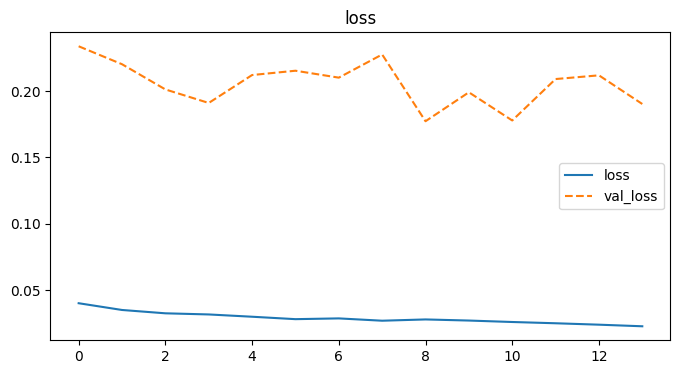

1/1 [==============================] - 5s 5s/step


In [33]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)
# processed_signal = processed_signal_FFT

input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)
model = build_Lstm_model(train_data, prediction_day, input_shape)

history = train_Lstm_model(train_data, model, x_train, y_train)
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data, model)
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

In [34]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [35]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  8.3
            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-07   8.0  2020-01-17    peak   9.51        0
data_1  2020-01-16  2020-01-28   3.0  2020-01-31  valley  12.17        0
data_2  2020-01-31  2020-02-11  -7.0  2020-01-31  valley  10.03        0
data_3  2020-02-14  2020-03-04  13.0  2020-03-23  valley  10.08        0
data_4  2020-03-02  2020-03-12   7.0  2020-03-23  valley  10.52        0
data_5  2020-03-16  2020-04-23   4.0  2020-04-29    peak   9.16        0
data_6  2020-03-30  2020-03-31   1.0  2020-04-01  valley  10.93        0
data_7  2020-04-14  2020-04-23   4.0  2020-04-29    peak  10.61        0
data_8  2020-04-28  2020-04-30  26.0  2020-06-08    peak  10.27        0
data_9  2020-05-12  2020-05-22  10.0  2020-06-08    peak  10.17        0


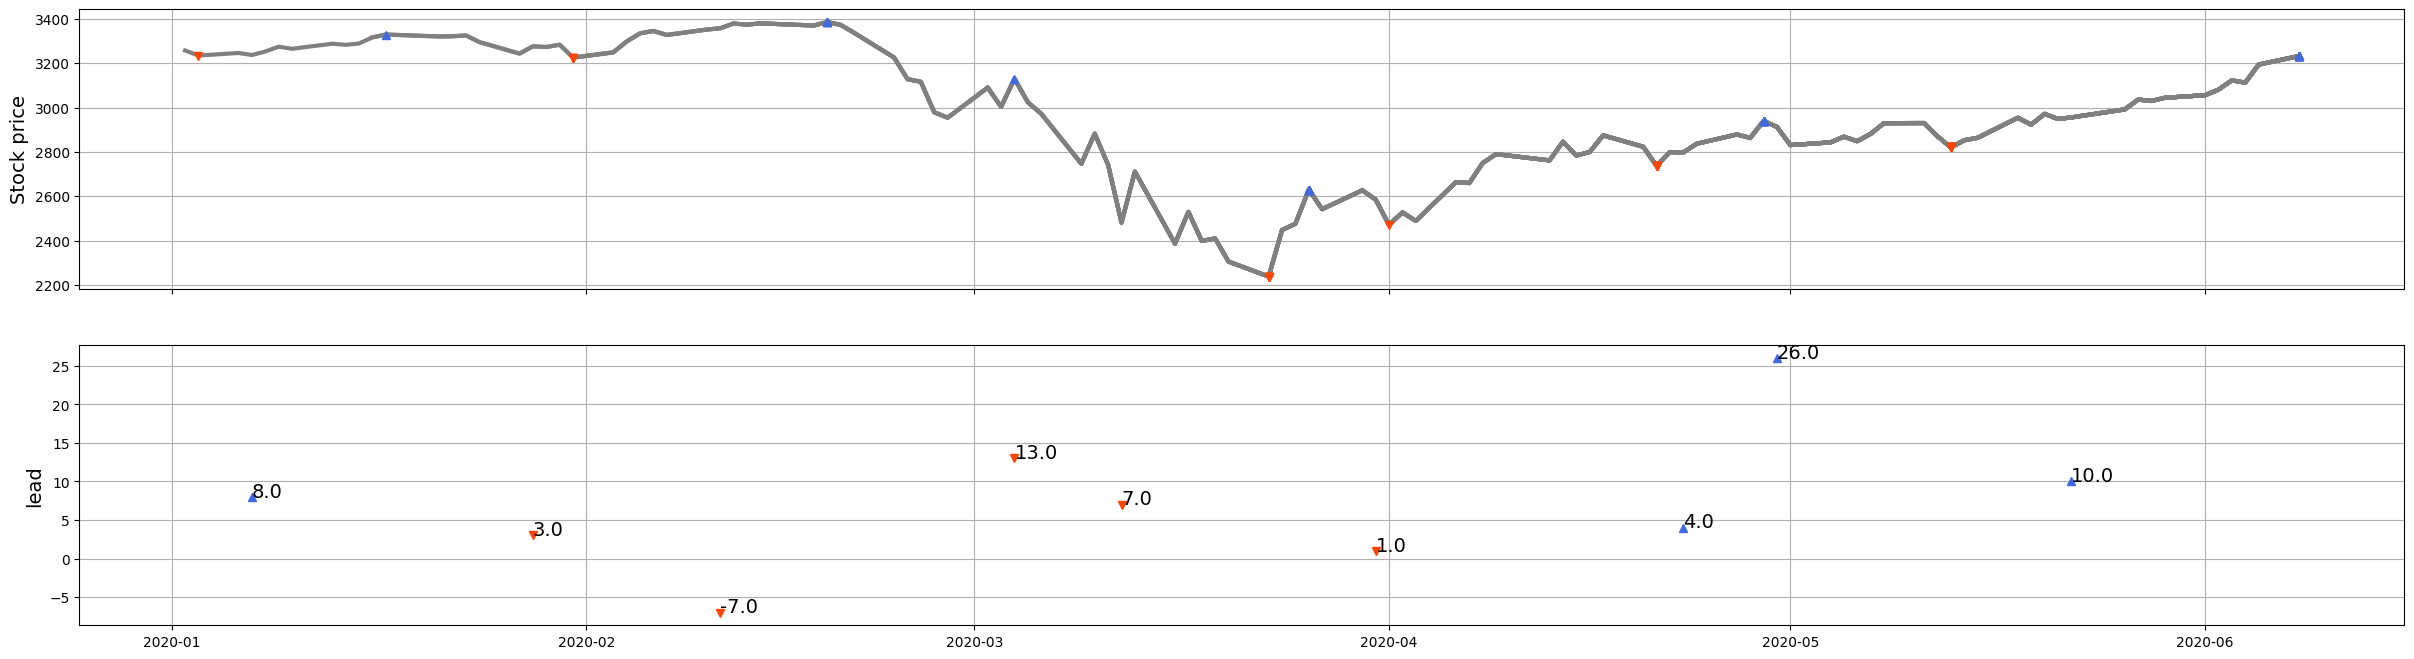

In [36]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

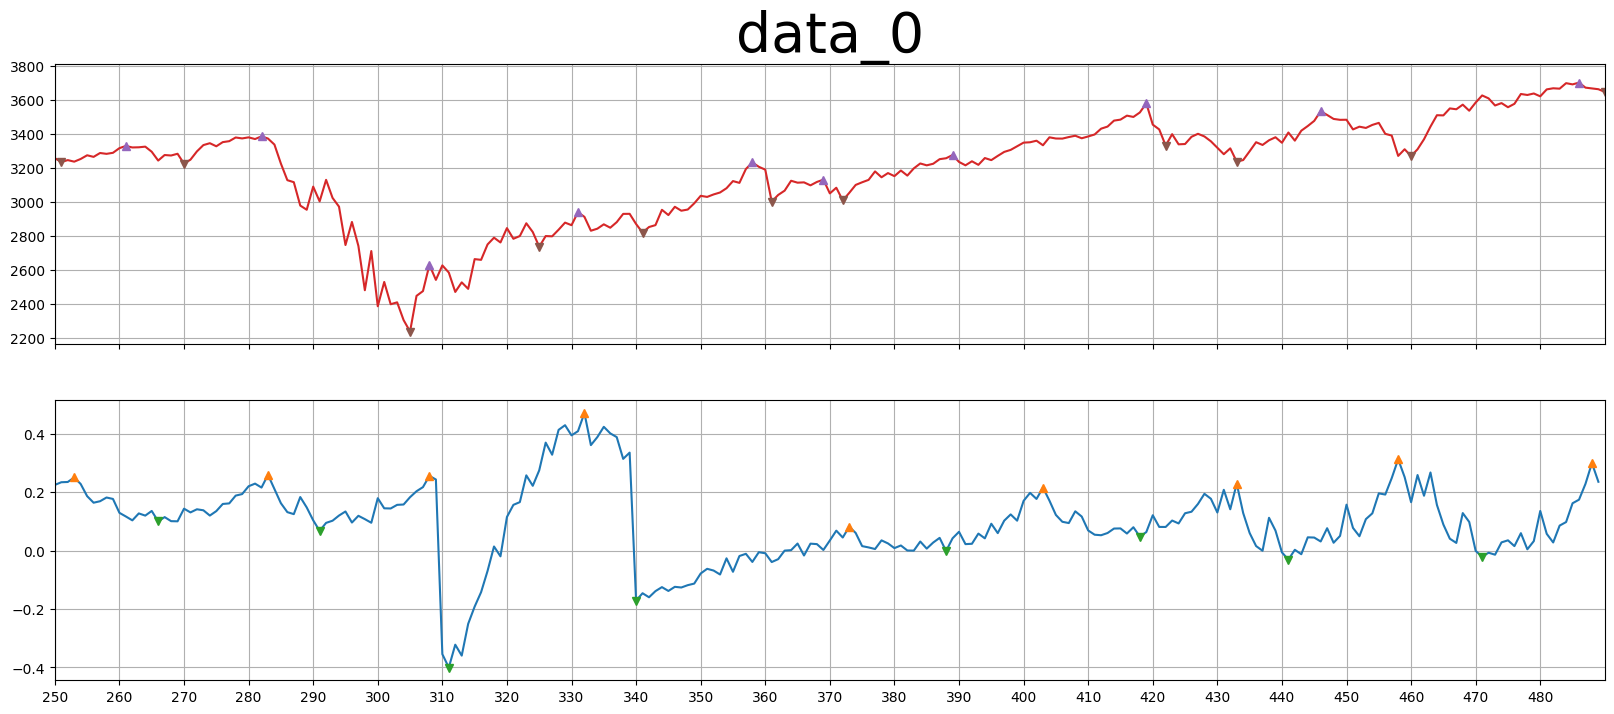

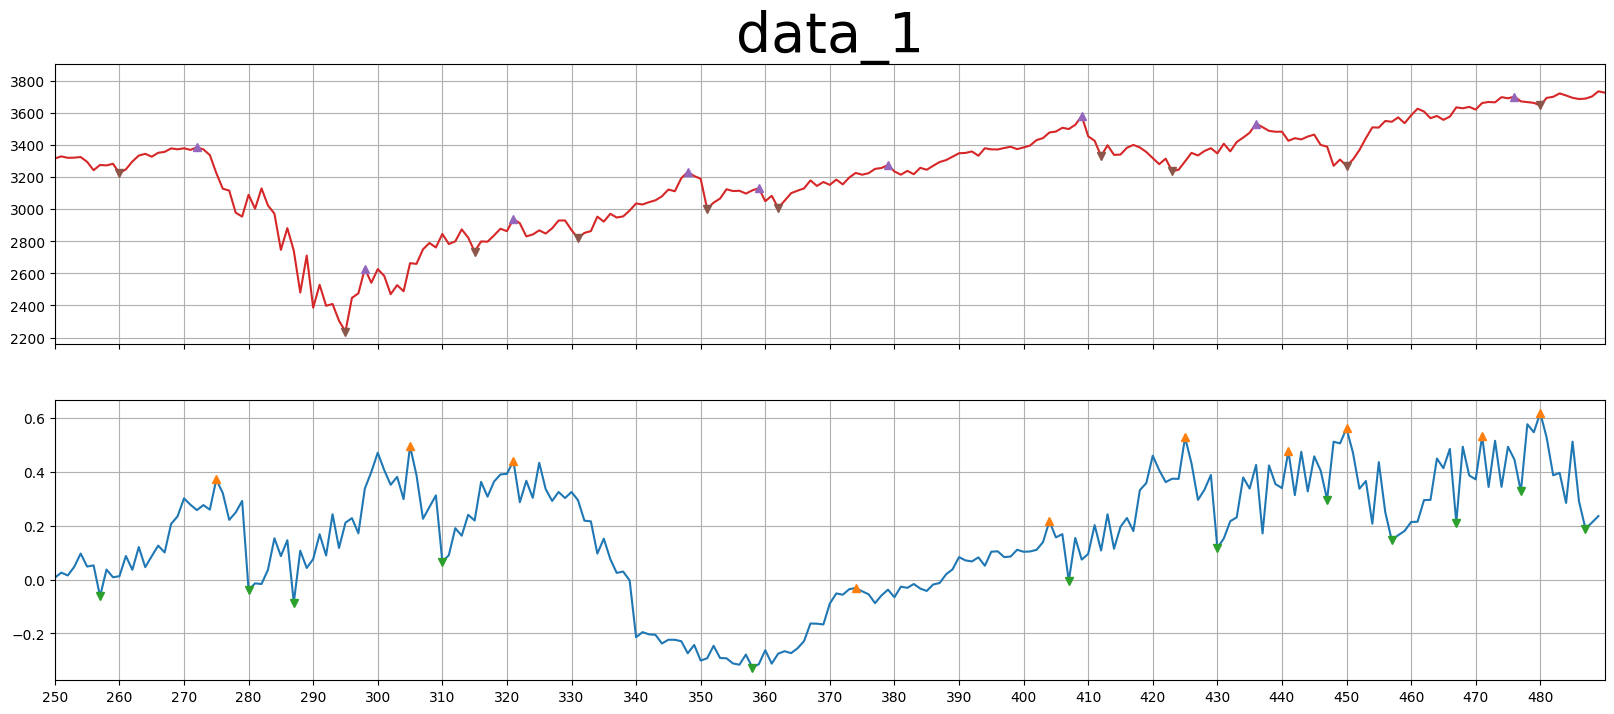

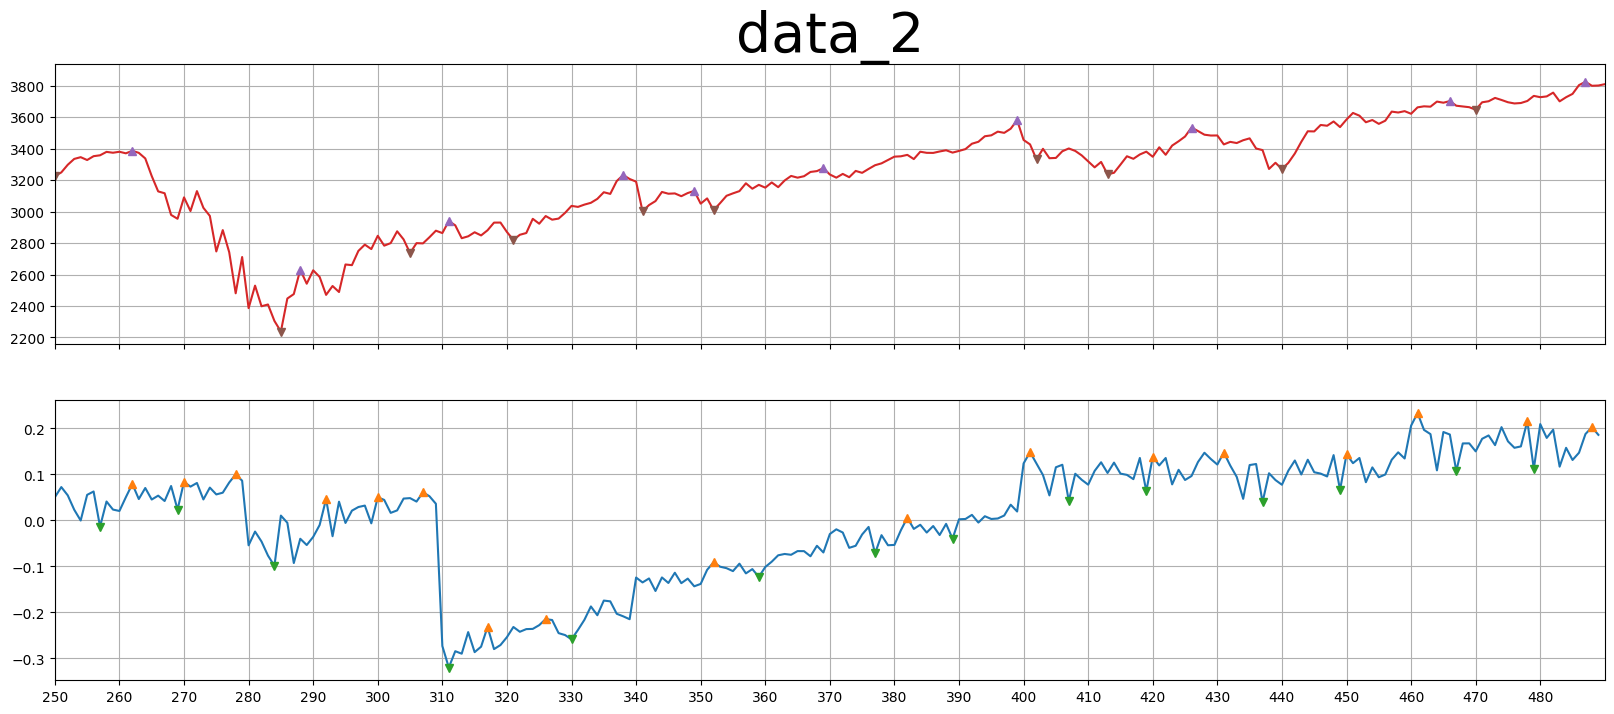

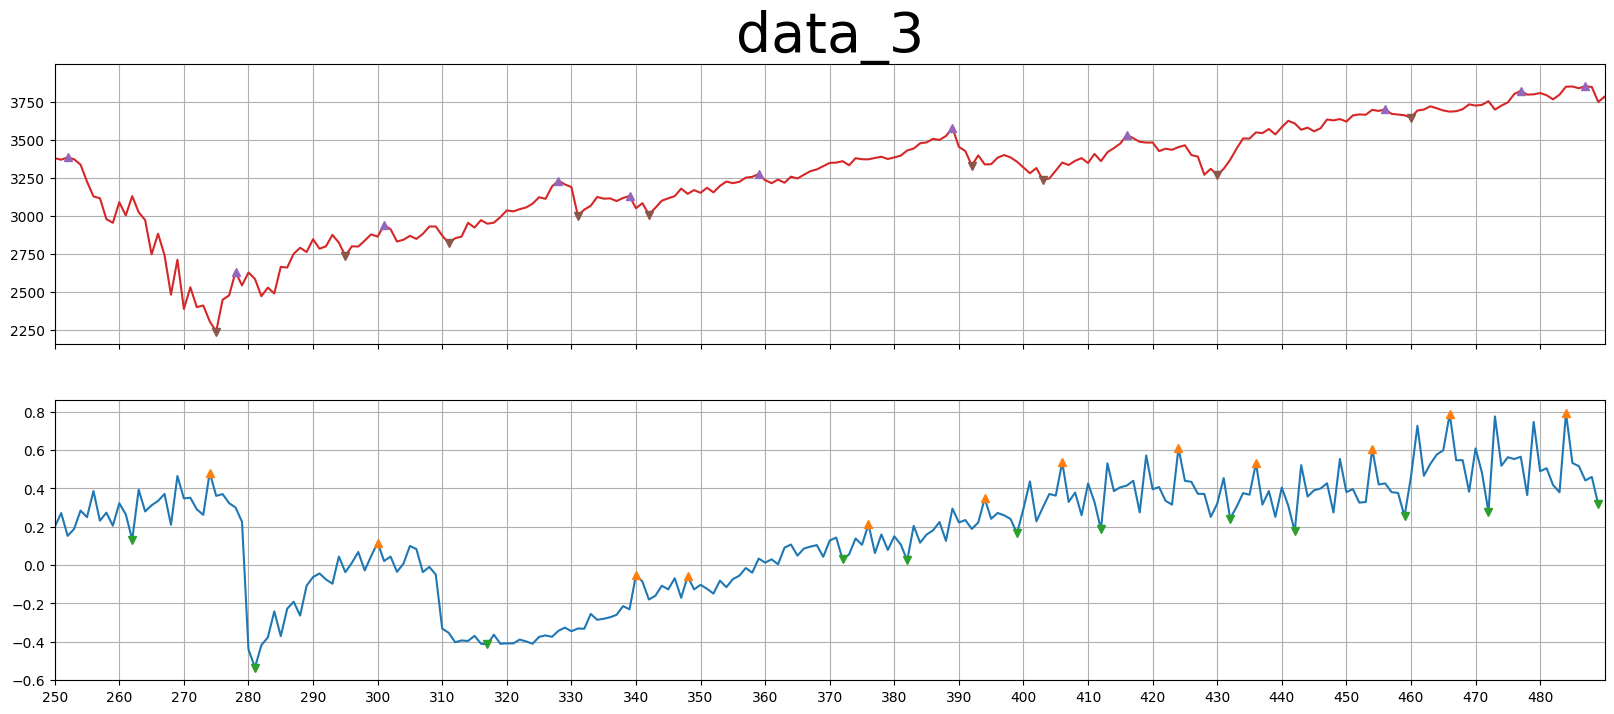

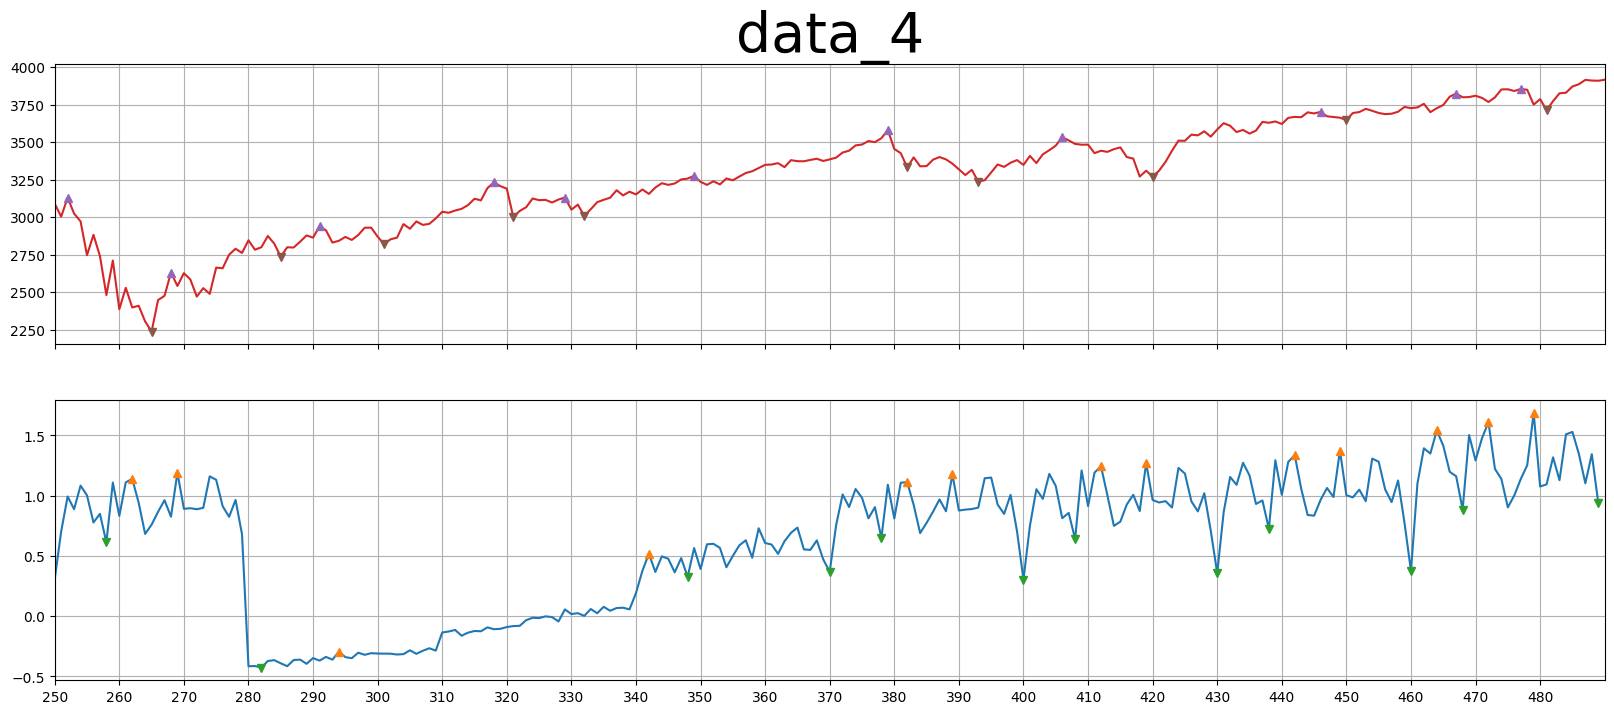

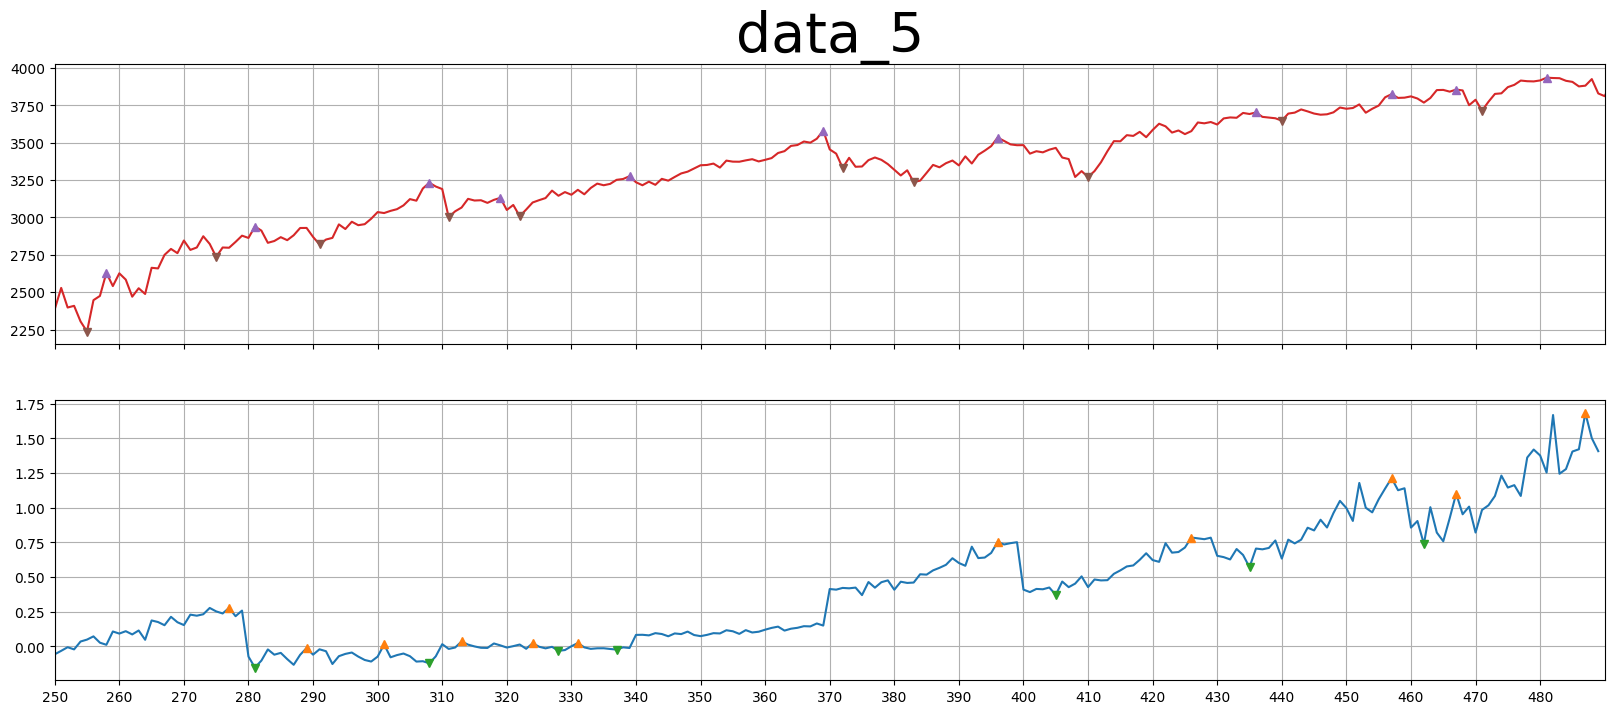

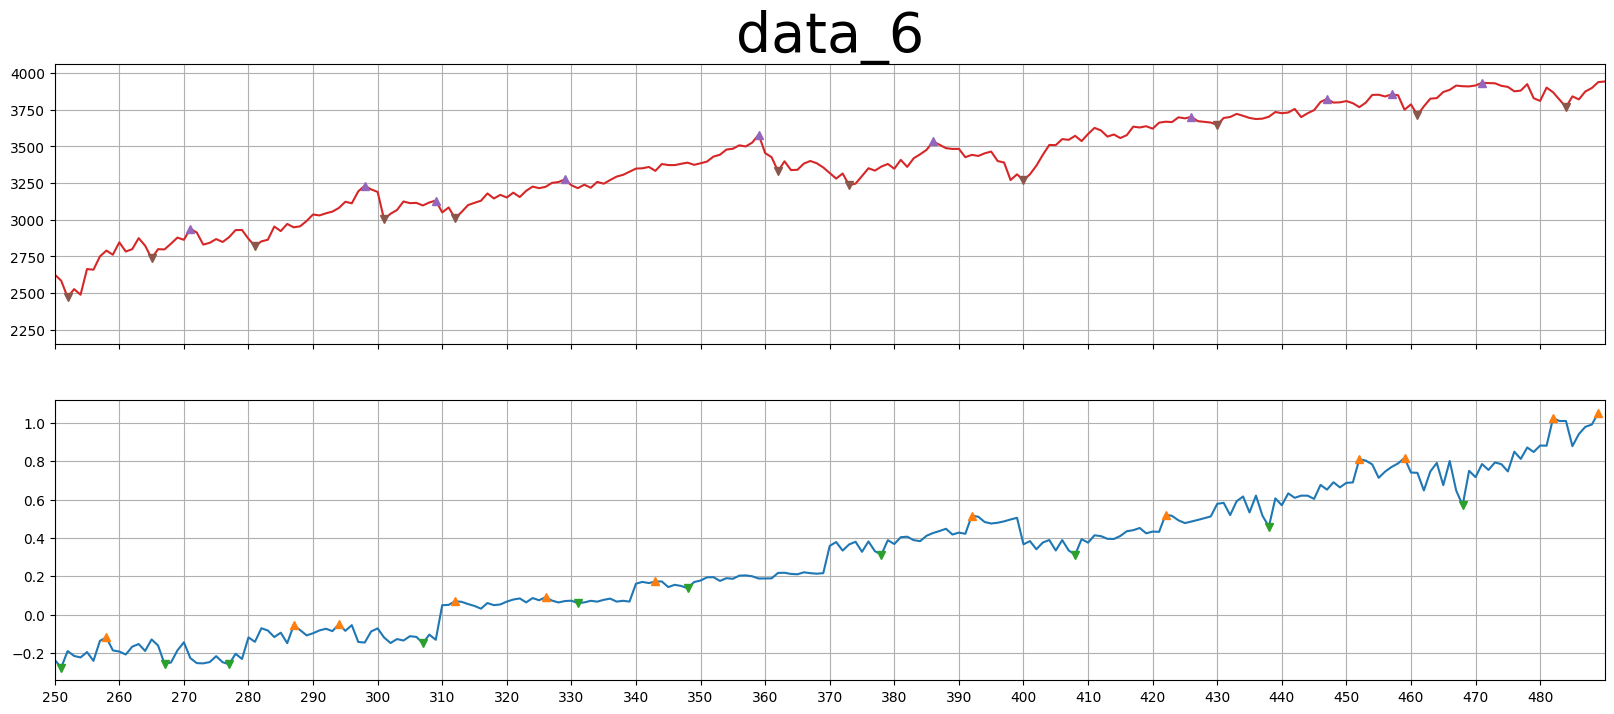

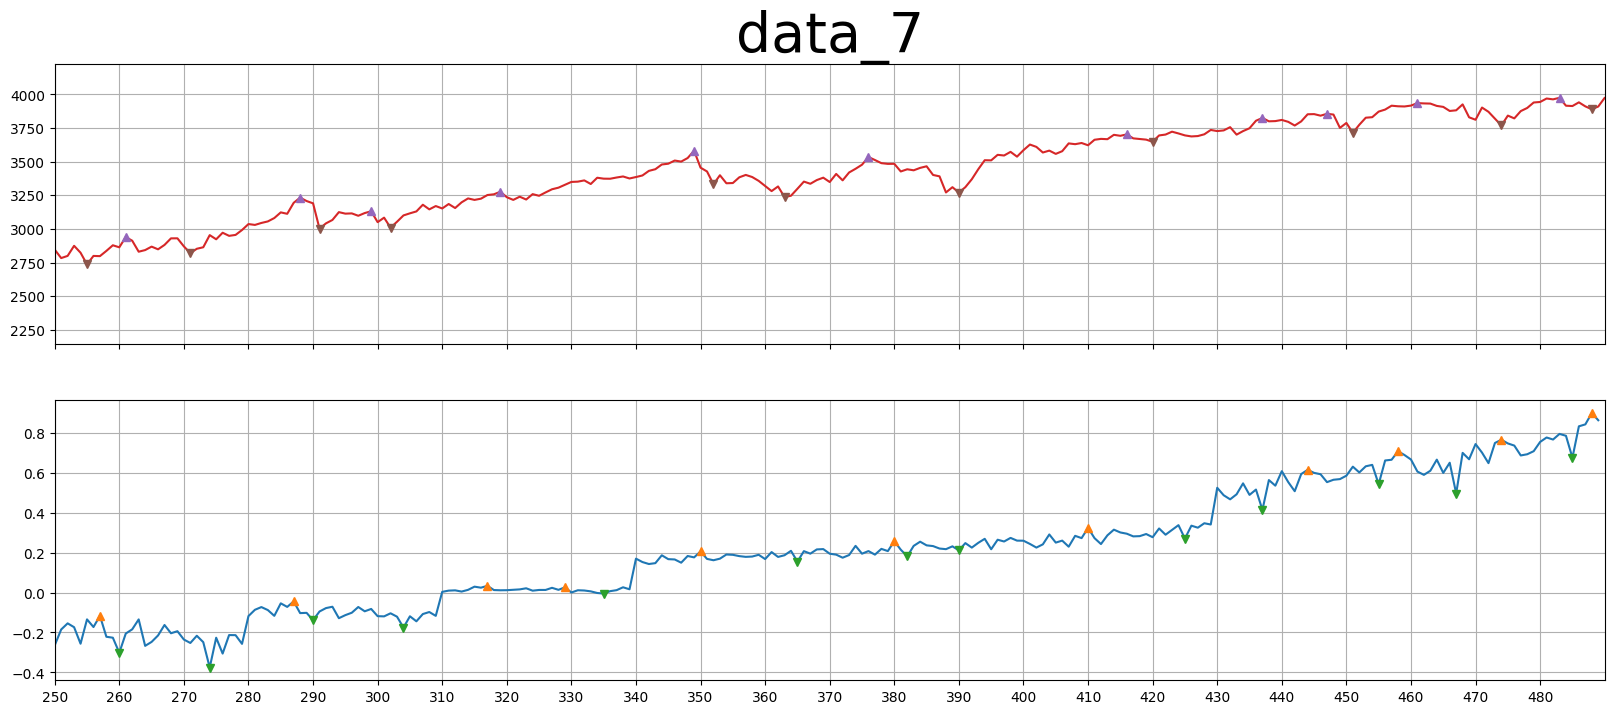

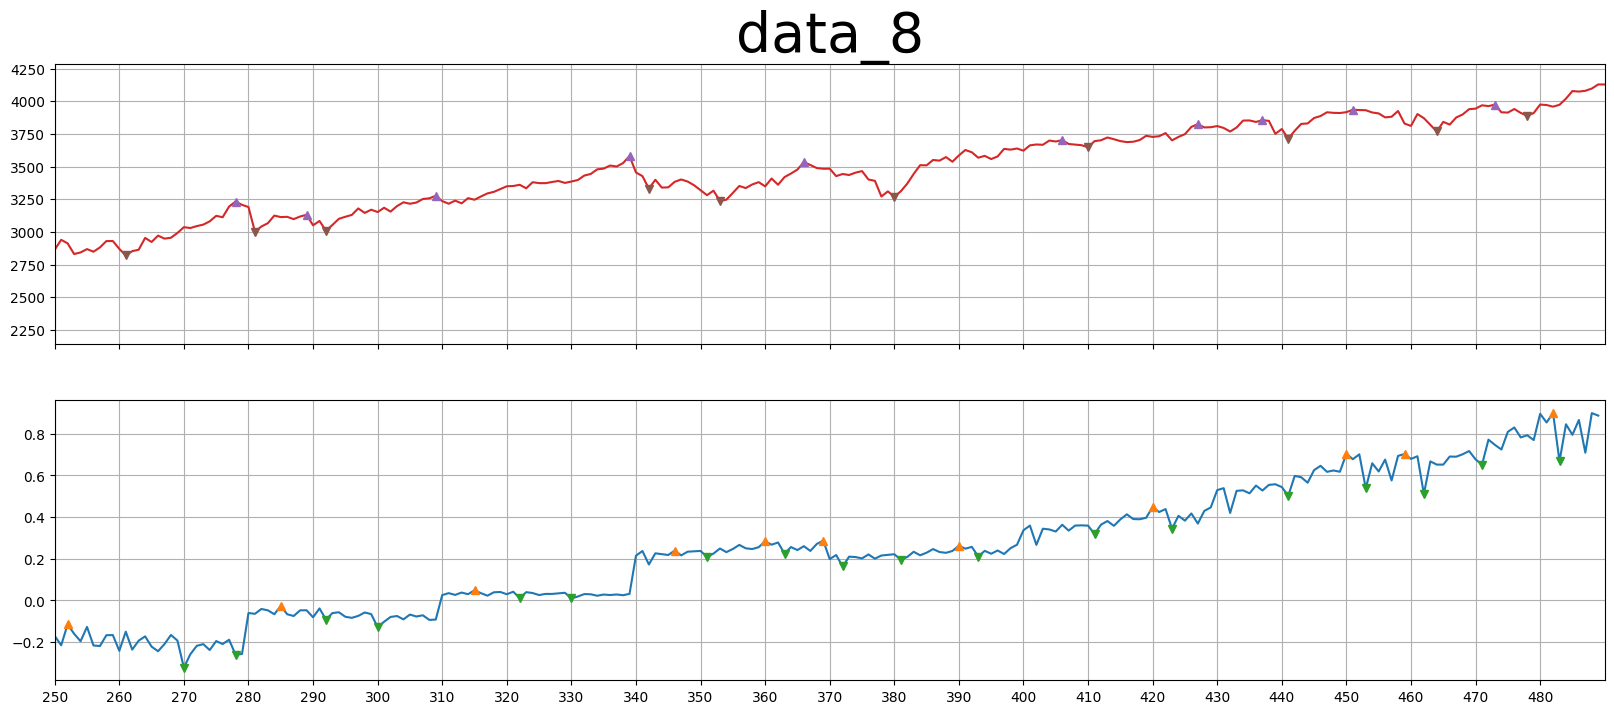

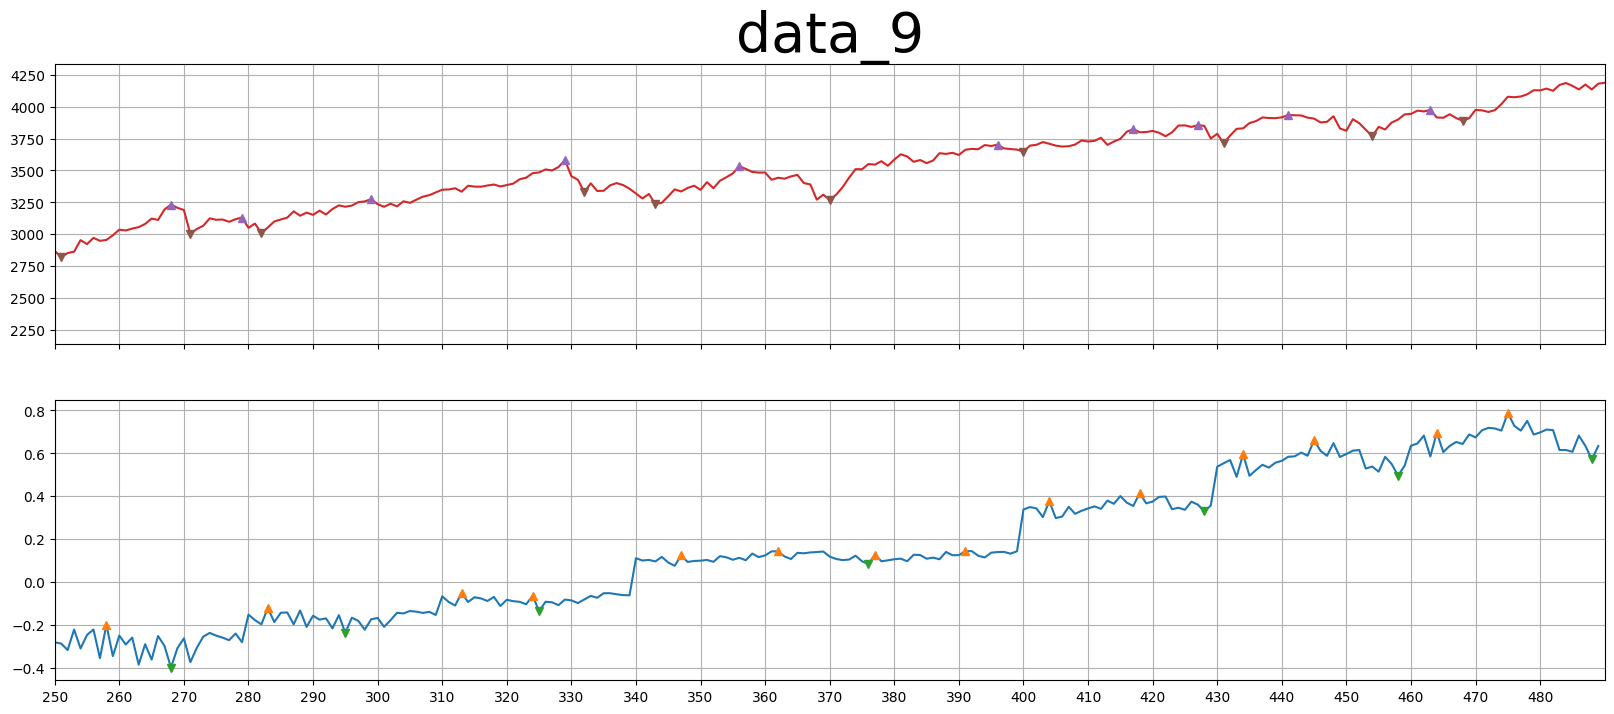

In [37]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

In [42]:
def build_profit_table_method_1(result_table):
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        out_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range]
        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        profit_table.loc[i, 'out_date'] = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range].name
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [43]:
total_profit, profit_table = build_profit_table_method_1(result_table)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = -762.26025390625
           in_date in_price    out_date out_price      pv  profit
data_0  2020-01-07  3237.18  2020-01-16   3316.81    peak  -79.63
data_1  2020-01-28  3276.24  2020-02-06   3345.78  valley   69.54
data_2  2020-02-11  3357.75  2020-02-21   3337.75  valley   -20.0
data_3  2020-03-04  3130.12  2020-03-13   2711.02  valley  -419.1
data_4  2020-03-12  2480.64  2020-03-23    2237.4  valley -243.24
data_5  2020-04-23   2797.8  2020-05-04   2842.74    peak  -44.94
data_6  2020-03-31  2584.59  2020-04-09   2789.82  valley  205.23
data_7  2020-04-23   2797.8  2020-05-04   2842.74    peak  -44.94
data_8  2020-04-30  2912.43  2020-05-11   2930.19    peak  -17.76
data_9  2020-05-22  2955.45  2020-06-03   3122.87    peak -167.42


In [44]:
def draw_profit_plot(profit_table, pv_range):
    date_list = sorted(
        list(profit_table['in_date']) + list(profit_table['out_date']))
    plot_data = all_data.loc[date_list[0]:date_list[-1]]
    find_data_pv_function(plot_data, pv_range)
    plt.figure(figsize=(20, 8))
    plt.plot(plot_data['Close'], label='real data')
    plt.plot(plot_data['peaks'], '^', label='peaks', c='royalblue')
    plt.plot(plot_data['valleys'], 'v', label='valleys', c='orangered')
    j=0
    for i in profit_table.index:
        plt.plot(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price'], '*', c='red')
        text = f'in_price_{j}:'+str(round(profit_table.loc[i, 'in_price'], 2))
        plt.annotate(text, (profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']-100), fontsize=14, c='red')

        plt.plot(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price'], '*', c='green')
        text = f'out_price_{j}:'+str(round(profit_table.loc[i, 'out_price'], 2))
        plt.annotate(text, (profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']+100), fontsize=14, c='green')
        j+=1

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.grid()
    plt.legend()
    plt.show()

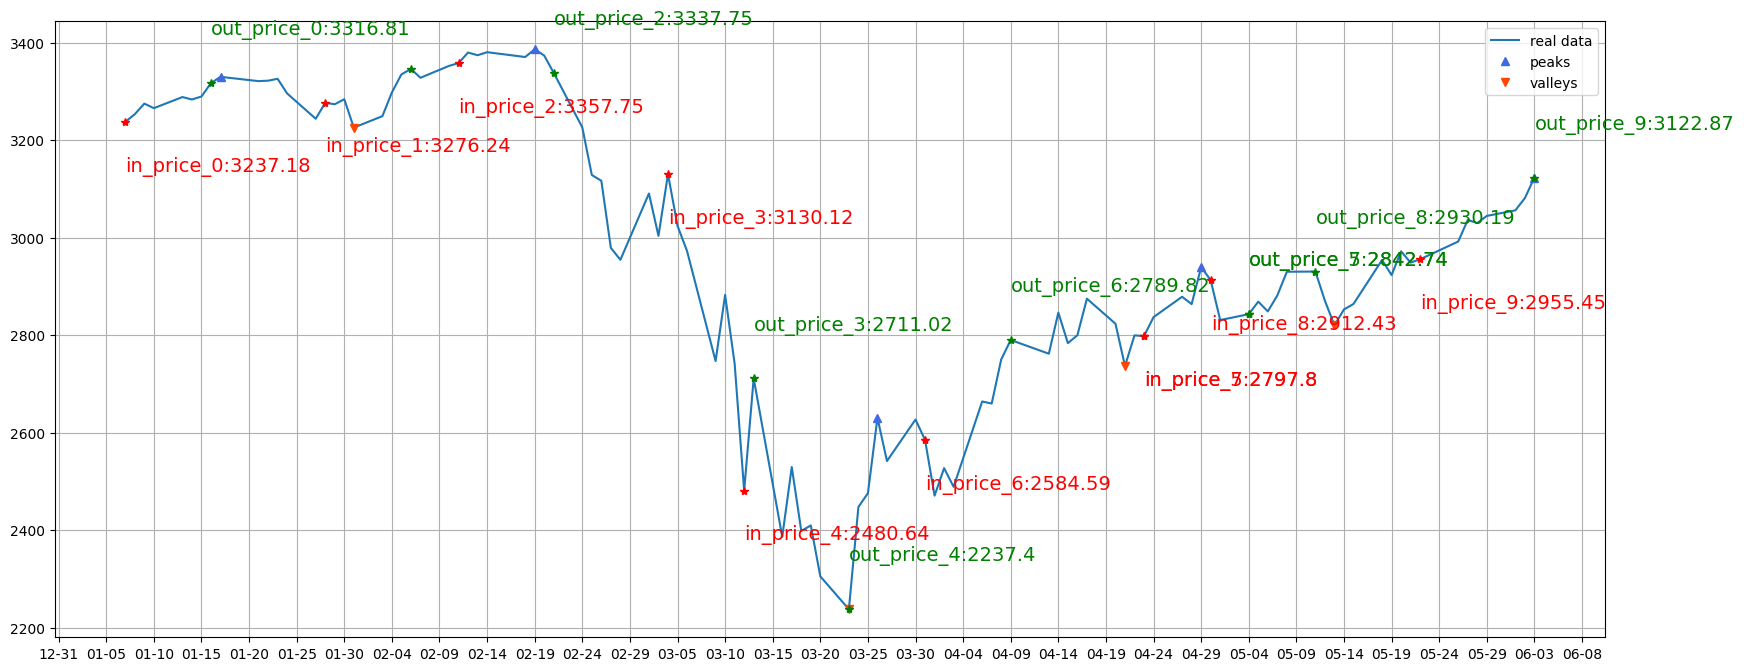

In [45]:
draw_profit_plot(profit_table, pv_range)